## Neural Network Regression for Score Prediction

This notebook implements a **PyTorch-based neural network pipeline** to predict continuous metric scores using both **text embeddings** and **metric embeddings**. The goal is to build a flexible, non-linear model that can learn richer interactions than tree-based methods.

---

## 1. Loading Data and Embeddings

We load:
- Augmented training features (`X_train_new_augmented.npy`)
- Corresponding training labels (`y_train_new_augmented.npy`)
- Test features (`X_test.npy`)
- Metric embeddings to help separate text vs. metric dimensions

This allows the neural network to combine structured metric signals with high-dimensional prompt embeddings.

---

##  2. Dimensionality Reduction 

Because the combined embedding space may be very large:
- PCA is applied to the text portion of the embeddings
- Reduces dimensionality while preserving variance
- Helps stabilize and speed up neural network training

This is especially helpful when training data is limited compared to embedding dimensionality.

---

##  3. Train–Validation Tensor Preparation

We convert NumPy arrays into PyTorch tensors:
- `X_train_tensor`
- `y_train_tensor`
- `X_val_tensor`
- `y_val_tensor`

TensorDataset + DataLoader are used for batching and shuffling, improving convergence.

---

##  4. Neural Network Architecture

The regression model is defined as:

- Fully connected feedforward network  
- Layer blocks with:
  - `Linear`  
  - `ReLU` activation  
  - `Dropout` for regularization  

This architecture captures non-linear relationships between embeddings and target scores.

---

##  5. Training Loop with Early Stopping

The model uses:
- **MSELoss** for continuous regression  
- **Adam optimizer** (`lr=1e-4`)  
- **Early stopping** based on validation loss  
  - Stops when no improvement for several epochs  
  - Prevents overfitting  

Training history is plotted for qualitative inspection.

---

##  6. Evaluation and Visualization

After training:
- We print validation metrics  
- Plot training vs. validation loss curves  
- Confirm whether the model overfits, underfits, or learns reasonably  

This helps guide hyperparameter tuning (layers, learning rate, PCA dimensions, etc.)

---


In [2]:
import numpy as np
import pandas as pd
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr, spearmanr
from warnings import filterwarnings
filterwarnings('ignore')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
train = json.load(open("data/train_data.json"))
test = json.load(open("data/test_data.json"))
metric_embs = np.load("data/metric_name_embeddings.npy")
metric_map = json.load(open("data/metric_names.json"))

In [ ]:
X = np.load("data/X_train_new_augmented.npy")
y = np.load("data/y_train_new_augmented.npy")
X_test = np.load("data/X_test.npy")

In [ ]:
from sklearn.mixture import GaussianMixture

metric_dim = metric_embs.shape[1]
text_dim = X.shape[1] - metric_dim
X_text = X[:, :text_dim]
X_metric = X[:, text_dim:]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Identify low-score region
low_thr = 6.0
low_mask = y <= low_thr
X_text_low = X_text[low_mask]
X_metric_low = X_metric[low_mask]
y_low = y[low_mask]

print(f"Low-score samples: {len(X_text_low)} / {len(X_text)}")

Low-score samples: 80 / 5000


In [ ]:
from sklearn.decomposition import PCA

pca_components = 64
pca = PCA(n_components=pca_components, random_state=42, svd_solver='auto', whiten=False)
Z_low = pca.fit_transform(X_text_low)

n_components = 5
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='diag',        
    random_state=42,
    reg_covar=1e-6
).fit(Z_low)

synth_multiplier = 10
n_synth = max(1, synth_multiplier * len(Z_low))
Z_synth, _ = gmm.sample(n_synth)
X_text_synth = pca.inverse_transform(Z_synth)


rng = np.random.default_rng(42)
idx = rng.integers(0, len(X_metric_low), size=n_synth)
X_metric_synth = X_metric_low[idx]

y_synth = np.clip(rng.normal(loc=3.0, scale=1.2, size=n_synth), 0.0, 6.0).astype(np.float32)

X_synth = np.hstack([X_text_synth.astype(np.float32), X_metric_synth.astype(np.float32)])
X_combined = np.vstack([X, X_synth])
y_combined = np.concatenate([y, y_synth])

X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [ ]:

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).float().reshape(-1, 1)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val).float().reshape(-1, 1)

# This is your final test data
X_test_tensor = torch.tensor(X_test)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total training samples: {X.shape[0]}")
print(f"New training set shape: {X_train_tensor.shape}")
print(f"Validation set shape: {X_val_tensor.shape}")
print(f"Test (inference) set shape: {X_test_tensor.shape}")

Total training samples: 5000
New training set shape: torch.Size([4640, 1536])
Validation set shape: torch.Size([1160, 1536])
Test (inference) set shape: torch.Size([3638, 1536])


In [ ]:

input_dim = X_train.shape[1]

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1) 
        )
    
    def forward(self, x):
        return self.network(x)

model = RegressionModel(input_dim).to(device)

# Print a summary
print("\n--- Model Architecture ---")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


--- Model Architecture ---
RegressionModel(
  (network): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)
Total trainable parameters: 852737


In [ ]:

criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

patience = 5
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None
num_epochs = 50

history = {'loss': [], 'val_loss': []}

print("\n--- Starting Model Training ---")

for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    history['loss'].append(avg_train_loss)
    
    model.eval()  
    val_loss = 0.0
    with torch.no_grad():  
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
    avg_val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict().copy()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
print("--- Training Complete (Best Model Loaded) ---")


--- Starting Model Training ---
Epoch 1/50 | Train Loss: 36.048170 | Val Loss: 5.614134
Epoch 2/50 | Train Loss: 5.588352 | Val Loss: 5.122201
Epoch 3/50 | Train Loss: 5.111877 | Val Loss: 4.792521
Epoch 4/50 | Train Loss: 4.743968 | Val Loss: 4.542727
Epoch 5/50 | Train Loss: 4.418410 | Val Loss: 4.348378
Epoch 6/50 | Train Loss: 4.176033 | Val Loss: 4.247275
Epoch 7/50 | Train Loss: 3.997587 | Val Loss: 4.067841
Epoch 8/50 | Train Loss: 3.816911 | Val Loss: 3.965656
Epoch 9/50 | Train Loss: 3.677303 | Val Loss: 3.890487
Epoch 10/50 | Train Loss: 3.527616 | Val Loss: 3.790206
Epoch 11/50 | Train Loss: 3.421325 | Val Loss: 3.734766
Epoch 12/50 | Train Loss: 3.347969 | Val Loss: 3.649913
Epoch 13/50 | Train Loss: 3.225797 | Val Loss: 3.609778
Epoch 14/50 | Train Loss: 3.115438 | Val Loss: 3.512094
Epoch 15/50 | Train Loss: 3.057519 | Val Loss: 3.505703
Epoch 16/50 | Train Loss: 2.999802 | Val Loss: 3.384228
Epoch 17/50 | Train Loss: 2.876598 | Val Loss: 3.349026
Epoch 18/50 | Train Los


--- Model Evaluation ---


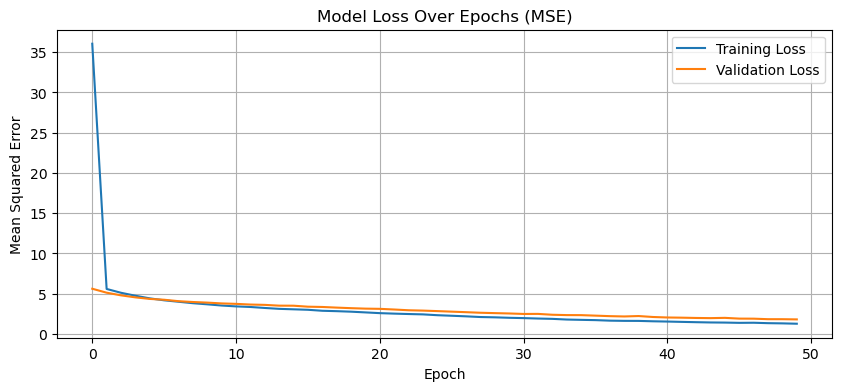

Validation RMSE: 1.3437
Validation Pearson Correlation (r): 0.8188
Validation Spearman Correlation (ρ): 0.5622


In [ ]:

print("\n--- Model Evaluation ---")

plt.figure(figsize=(10, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
val_predictions_list = []
y_val_list = []
with torch.no_grad():
    for inputs, labels in val_loader:
        val_predictions_list.append(model(inputs.to(device)))
        y_val_list.append(labels)

val_predictions_np = torch.cat(val_predictions_list, dim=0).cpu().numpy().flatten()
y_val_np = torch.cat(y_val_list, dim=0).cpu().numpy().flatten()

val_rmse = root_mean_squared_error(y_val_np, val_predictions_np)
val_pearson = pearsonr(y_val_np, val_predictions_np)[0]
val_spearman = spearmanr(y_val_np, val_predictions_np)[0]

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation Pearson Correlation (r): {val_pearson:.4f}")
print(f"Validation Spearman Correlation (ρ): {val_spearman:.4f}")

In [ ]:

print("\n--- Generating Final Predictions on Test Data ---")

test_dataset = TensorDataset(X_test_tensor) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
final_predictions_list = []
with torch.no_grad():
    for inputs in test_loader:
        inputs_tensor = inputs[0].to(device)
        final_predictions_list.append(model(inputs_tensor))

final_predictions = torch.cat(final_predictions_list, dim=0).cpu().numpy().flatten()

print("First 10 automated scores:")
for i, score in enumerate(final_predictions[:10]):
    print(f"  Test Sample {i}: {score:.4f}")


--- Generating Final Predictions on Test Data ---
First 10 automated scores:
  Test Sample 0: 9.2290
  Test Sample 1: 9.3616
  Test Sample 2: 8.6748
  Test Sample 3: 9.6757
  Test Sample 4: 3.5591
  Test Sample 5: 9.4616
  Test Sample 6: 8.9469
  Test Sample 7: 7.8825
  Test Sample 8: 8.9346
  Test Sample 9: 7.3870
